In [1]:
import sys
import os
import numpy as np
import pandas as pd
import cv2
from imageio import imread
import matplotlib.pyplot as plt
import torch

sys.path.append('../../')
from src.utils.common import set_gpu
from src.models.predictor.keypoint import Predictor
from src.models.predictor.keypoint.evaluate import Evaluator
from src.visualize.keypoint_visualization import draw_points_and_skeleton, joints_dict

## Preparation for Evaluation 

### Load Configurartion

In [2]:
from hydra.experimental import initialize, compose
from omegaconf import OmegaConf

with initialize(config_path="../../configs"):
    cfg = compose(overrides=["+data=keypoint",
                             "+test=keypoint",
                             "+system=system",])
    model_cfg = compose(overrides=["+model=keypoint/hrnet",
                             "+loss=keypoint"])
    print(cfg)
    print(model_cfg)

{'DATA': {'DATA_ID': 'demo_keypoint', 'CSV_PATH': 'demo_trainval.pkl', 'N_FOLD': 1, 'FORMAT': 'mpii', 'BASE_SIZE': 256.0, 'BASE_SIGMA': 2.0, 'SCALE_AWARE_SIGMA': False, 'SCALE_TYPE': 'short', 'SIGMA': 2, 'WITH_CENTER': False, 'INT_SIGMA': False, 'MAX_NUM_PEOPLE': 30}, 'TEST': {'BATCH_SIZE': 1, 'DETECTION_THRESHOLD': 0.1, 'PCK_FACTOR': 0.5, 'PCK_THRESHOLD': 100, 'OKS_FACTOR': 0.1, 'OKS_THRESHOLD': 0.5}, 'SYSTEM': {'DEVICE': 'GPU', 'GPUS': [1], 'SEED': False, 'NUM_WORKERS': 4, 'CUDNN': {'ENABLED': True, 'BENCHMARK': True, 'DETERMINISTIC': False}}}
{'MODEL': {'MODEL_NAME': 'kpt_higher_hrnet', 'BACKBONE': 'hrnet', 'WEIGHT_PATH': 'pretrained/best_loss.pth', 'WO_HEAD': False, 'INPUT_SIZE': 512, 'OUTPUT_SIZE': [128, 256], 'NUM_JOINTS': 16, 'TAG_PER_JOINT': True, 'EXTRA': {'DECONV': {'CAT_OUTPUT': [True], 'KERNEL_SIZE': [4], 'NUM_BASIC_BLOCKS': 4, 'NUM_CHANNELS': [32], 'NUM_DECONVS': 1}, 'FINAL_CONV_KERNEL': 1, 'PRETRAINED_LAYERS': ['*'], 'STAGE2': {'BLOCK': 'BASIC', 'FUSE_METHOD': 'SUM', 'NUM

### select device 

In [3]:
gpu_id = [int(gid) for gid in cfg.SYSTEM.GPUS]
set_gpu(gpu_id)

Device GPU is selected
GPUID: [1]


### Load Predictor 

In [4]:
joints_set = cfg.DATA.FORMAT
jdict = joints_dict()[joints_set]

model_cfg.MODEL.WO_HEAD = False
model_cfg.MODEL.WEIGHT_PATH = 'pretrained/best_loss.pth'

model = Predictor(
    cfg,
    model_cfg,
    return_bounding_boxes=False
)

### Load Evaluation dataset

In [5]:
df = pd.read_pickle('../../data/demo_keypoint/split/demo_trainval.pkl')

## Single image Evaluation

### Prepare  data

In [43]:
idx = 1
img = imread(df.image_path.iloc[idx])
joints = df.joints.iloc[idx]

### Prediction

In [44]:
pts = model.predict_image(img)

### Visualize

In [45]:
person_ids = np.arange(len(pts), dtype=np.int32)

for i, (pt, pid) in enumerate(zip(pts, person_ids)):
    img = draw_points_and_skeleton(img, pt, jdict['skeleton'], person_index=pid,
                                   points_color_palette='gist_rainbow', skeleton_color_palette='jet',
                                   points_palette_samples=10, confidence_threshold=0.2)

gt_img = imread(df.image_path.iloc[idx])
person_ids = np.arange(len(joints), dtype=np.int32)

for i, (pt, pid) in enumerate(zip(joints, person_ids)):
    gt_img = draw_points_and_skeleton(gt_img, pt, jdict['skeleton'], person_index=pid,
                                   points_color_palette='gist_rainbow', skeleton_color_palette='jet',
                                   points_palette_samples=10, confidence_threshold=0)

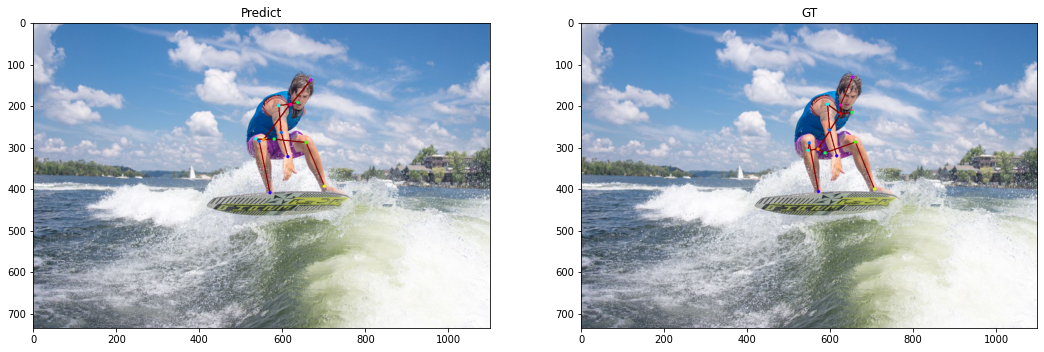

In [46]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,18))

ax1.imshow(img)
ax1.set_title('Predict')
ax2.imshow(gt_img)
ax2.set_title('GT')
plt.show()

### Load Evaluator

In [10]:
#You should check jdict['keypoints'] to set the correct value for 'head_neck'
#if there is no corresponding keypoint, 'head_neck' should be 'None'
jdict['keypoints']

{0: 'right_ankle',
 1: 'right_knee',
 2: 'right_hip',
 3: 'left_hip',
 4: 'left_knee',
 5: 'left_ankle',
 6: 'pelvis',
 7: 'thorax',
 8: 'upper_neck',
 9: 'head top',
 10: 'right_wrist',
 11: 'right_elbow',
 12: 'right_shoulder',
 13: 'left_shoulder',
 14: 'left_elbow',
 15: 'left_wrist'}

In [11]:
evaluator = Evaluator(num_joints=cfg.MODEL.NUM_JOINTS,
                      conf_thresh=cfg.TEST.DETECTION_THRESHOLD,
                      head_neck=(8,9))

### Execute Evaluation based on PCK

In [12]:
confmat = evaluator.calc_confmat(pts, joints, metrics='pck')
eval_df = pd.DataFrame(confmat, columns=(['TP', 'FP', 'FN', 'TN']), index=jdict['keypoints'].values())
print(eval_df)

                 TP   FP   FN   TN
right_ankle     4.0  0.0  0.0  0.0
right_knee      4.0  1.0  0.0  0.0
right_hip       4.0  0.0  0.0  0.0
left_hip        3.0  2.0  1.0  0.0
left_knee       3.0  2.0  1.0  0.0
left_ankle      4.0  1.0  0.0  0.0
pelvis          4.0  1.0  0.0  0.0
thorax          4.0  0.0  0.0  0.0
upper_neck      4.0  0.0  0.0  0.0
head top        4.0  0.0  0.0  0.0
right_wrist     3.0  1.0  0.0  0.0
right_elbow     3.0  1.0  0.0  0.0
right_shoulder  4.0  0.0  0.0  0.0
left_shoulder   4.0  0.0  0.0  0.0
left_elbow      4.0  1.0  0.0  0.0
left_wrist      4.0  1.0  0.0  0.0


In [13]:
print("PCK")
print(eval_df.TP / (eval_df.TP+eval_df.FP) * 100)

PCK
right_ankle       100.0
right_knee         80.0
right_hip         100.0
left_hip           60.0
left_knee          60.0
left_ankle         80.0
pelvis             80.0
thorax            100.0
upper_neck        100.0
head top          100.0
right_wrist        75.0
right_elbow        75.0
right_shoulder    100.0
left_shoulder     100.0
left_elbow         80.0
left_wrist         80.0
dtype: float64


### Execute Evaluation based on OKS

In [14]:
confmat = evaluator.calc_confmat(pts, joints, metrics='oks')
eval_df = pd.DataFrame([confmat], columns=(['TP', 'FP', 'FN', 'TN']))
print(eval_df)

    TP   FP   FN   TN
0  4.0  1.0  0.0  0.0


In [15]:
print('Precision: ', (eval_df.TP / (eval_df.TP+eval_df.FP)).iloc[0])

Precision:  0.8


## Whole data Evaluation 

### make dataloader 

In [33]:
from src.data.generator.keypoint import make_test_dataloader
#TODO: batch_size１以上設定できるようにする。
test_dataloader = make_test_dataloader(df, batch_size=1, num_workers=1)

### AP(OKS): 画像全体でPrecision算出

In [35]:
results = model.predict(test_dataloader)

100%|##########| 4/4 [00:00<00:00,  4.33it/s]


In [36]:
sum_conf = np.sum(results.evaluate_result, axis=0)
sum_conf[0]/(sum_conf[0]+sum_conf[1])

0.875

### PCK

In [39]:
results = model.predict(test_dataloader, metrics='pck')

100%|##########| 4/4 [00:00<00:00,  4.26it/s]


In [42]:
sum_conf = np.sum(results.evaluate_result, axis=0)
sum_conf[:,0] / (sum_conf[:,0]+sum_conf[:,1])*100

array([100.        ,  87.5       , 100.        ,  85.71428571,
        87.5       ,  87.5       ,  85.71428571, 100.        ,
       100.        , 100.        ,  83.33333333,  71.42857143,
       100.        , 100.        ,  85.71428571,  71.42857143])